In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import numpy as np
import seaborn as sns
import tensorflow as tf
tf.__version__

'2.0.0-beta0'

In [4]:
from environment import TradingEnvironment
from market_instance import new_market, make_investors

### Configuration for the synthetic market

In [5]:
config = {
    'num_investors': 10,
    'num_rounds_per_day': 3
}

### Our own portfolio

In [6]:
holdings = {
    'cash': 100000.00, 
    'TSLA': 300, 
    'AAPL': 200, 
    'MSFT': 400}

### Create the RL Environment

In [7]:
market = new_market()
environment = TradingEnvironment(config, holdings, market, 0.002)

## The market in action

In [8]:
for _ in range(360):
    market.open()
    daily = environment.let_others_trade()
    market.close()

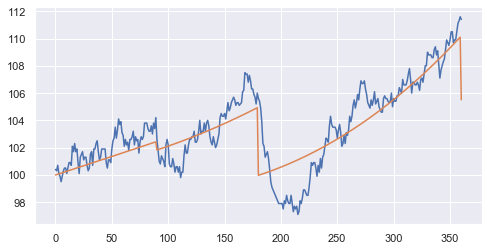

In [9]:
def plot(ticker):
    sns.set(rc={'figure.figsize':(8.0,4.0)})
    h = market.history_for(ticker)
    s = market.stocks[ticker]
    p_open, p_close, p_high, p_low = np.transpose(h)
    t = np.array(range(len(p_open)))
    sns.lineplot(t, p_open);
    sns.lineplot(t, [s.psi(tt) for tt in t]);
plot('AAPL')

## Perform an Action = Re-Balance

In [10]:
target_weights = np.array([.1, .3, .4, .2])

In [11]:
investor = environment.investor
print(investor, environment.total_wealth())
environment.act(target_weights)
print(investor, environment.total_wealth())

WB (cash: 100000.0, {'TSLA': 300, 'AAPL': 200, 'MSFT': 400}) 252405.5
WB (cash: 50392.136, {'TSLA': 696, 'AAPL': 228, 'MSFT': 349}) 252674.352


In [12]:
# slightly off-target because of integer stock counts and the trading costs.
environment.normalized_holdings()

array([0.09935475, 0.29689144, 0.40431871, 0.19943511])

### The ANN-based Trader Model

In [13]:
N_LSTM_NEURONS = 128
N_STOCKS = len(holdings)-1
BATCH_SIZE = 128
N_STEPS = 20                  # history length for the LSTM
N_OUT = N_STOCKS + 1          # stocks and cash
# current log returns, positions' weights, cash weight
N_FEATURES = N_STOCKS * 2 + 1

In [14]:
from models import LSTM_TraderModel

In [15]:
lstm_model = LSTM_TraderModel(
    n_neurons=N_LSTM_NEURONS, 
    n_steps=N_STEPS,
    n_features=N_FEATURES,
    n_out=N_OUT)

x = np.random.random(
    [BATCH_SIZE, N_STEPS, N_FEATURES]).astype(np.float32)

y = lstm_model(x) # initialize the model
test_portfolio = lstm_model.portfolio(x)
lstm_model.summary()

Model: "lstm__trader_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  multiple                  69632     
_________________________________________________________________
dense (Dense)                multiple                  516       
Total params: 70,148
Trainable params: 70,148
Non-trainable params: 0
_________________________________________________________________


In [16]:
x = np.random.random(
    [1, 5, N_FEATURES]).astype(np.float32)
x

array([[[0.5731483 , 0.61382055, 0.22824746, 0.43258625, 0.51062214,
         0.8428224 , 0.6184216 ],
        [0.6833221 , 0.5771418 , 0.6763991 , 0.7384522 , 0.19325969,
         0.26382515, 0.6388402 ],
        [0.15704378, 0.13449386, 0.76813656, 0.8802981 , 0.57496727,
         0.06499384, 0.77114344],
        [0.7380361 , 0.18202159, 0.4444427 , 0.9904318 , 0.2604383 ,
         0.50654304, 0.12577385],
        [0.7167988 , 0.4399137 , 0.3240548 , 0.3650921 , 0.64259714,
         0.6106306 , 0.3452912 ]]], dtype=float32)

In [17]:
lstm_model.portfolio(x)

<tf.Tensor: id=1705, shape=(1, 4), dtype=float32, numpy=array([[0.2596606 , 0.24784465, 0.26289532, 0.22959943]], dtype=float32)>

### Observation And Reward
The observation consists of the normalized holdings and the normalized log returns of the traded assets with respect to the closing prices. 

In [18]:
obs, reward = environment.act([.2, .2, .3, .3])
print("Observations: 4x normalized holdings, 3x normalized log returns:")
print(obs)
print("Reward: %s" % reward)

Observations: 4x normalized holdings, 3x normalized log returns:
[ 0.19917658  0.19968875  0.30238749  0.29874717 -0.18296831 -0.40700148
  0.41003021]
Reward: -0.0006998330454152647


Observe the time lag. This is a super-expensive method. We may need to consider parallel execution with Ray here...;-(